# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
!pip install requests --q

In [3]:
import requests

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

with open('image-predictions.tsv', mode='wb') as f:
    f.write(r.content)
    
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t')
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
!pip install tweepy -q

In [5]:
import tweepy

access_token = ""
access_secret = ""
consumer_key = ""
consumer_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
import pandas as pd

data = pd.read_csv('tweet-json.txt', sep = "\t", names=['tweets'])
data.head()
# names=["id", "favorite_count", "retweet_count"]

,tweets
0,"{""created_at"": ""Tue Aug 01 16:23:56 +0000 2017..."
1,"{""created_at"": ""Tue Aug 01 00:17:27 +0000 2017..."
2,"{""created_at"": ""Mon Jul 31 00:18:03 +0000 2017..."
3,"{""created_at"": ""Sun Jul 30 15:58:51 +0000 2017..."
4,"{""created_at"": ""Sat Jul 29 16:00:24 +0000 2017..."


In [7]:
import json

# json_temp = json.loads(data.loc[0]['tweets'])

twitter_list = []
cols = ["id", "favorite_count", "retweet_count"]

for row in data['tweets']:
    json_row = json.loads(row)
    twitter_list.append({'id': json_row['id_str'], \
                        'retweet_count': json_row['retweet_count'],\
                        'favorite_count': json_row['favorite_count'], 
                        'followers': json_row['user']['followers_count'],
                        'friends': json_row['user']['friends_count'],
                        'timestamp': json_row['created_at']})

df = pd.DataFrame(twitter_list, columns=['id', 'favorite_count', 'retweet_count', 'followers', 'friends', 'timestamp'])

In [8]:
df.head()

,id,favorite_count,retweet_count,followers,friends,timestamp
0,892420643555336193,39467,8853,3200889,104,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,33819,6514,3200889,104,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,25461,4328,3200889,104,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,42908,8964,3200889,104,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,41048,9774,3200889,104,Sat Jul 29 16:00:24 +0000 2017


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Explore "df" dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 6 columns):
id                2354 non-null object
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
followers         2354 non-null int64
friends           2354 non-null int64
timestamp         2354 non-null object
dtypes: int64(4), object(2)
memory usage: 110.4+ KB


In [10]:
df.describe()

,favorite_count,retweet_count,followers,friends
count,2354.000000,2354.000000,2.354000e+03,2354.0
mean,8080.968564,3164.797366,3.200942e+06,104.0
std,11814.771334,5284.770364,4.457302e+01,0.0
min,0.000000,0.000000,3.200799e+06,104.0
25%,1415.000000,624.500000,3.200898e+06,104.0
50%,3603.500000,1473.500000,3.200945e+06,104.0
75%,10122.250000,3652.000000,3.200953e+06,104.0
max,132810.000000,79515.000000,3.201018e+06,104.0


In [11]:
df.dtypes

id                object
favorite_count     int64
retweet_count      int64
followers          int64
friends            int64
timestamp         object
dtype: object

In [12]:
df.isnull().sum()

id                0
favorite_count    0
retweet_count     0
followers         0
friends           0
timestamp         0
dtype: int64

In [13]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
np.unique(twitter_archive.name)

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber', 'Ambrose',
       'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel', 'Anna',
       'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen', 'Arlo',
       'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh', 'Aspen',
       'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn', 'Ava',
       'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo', 'Barclay',
       'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter', 'Bayley',
       'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo', 'Bell',
       'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny', 'Bentley',
       'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson', 'Betty', 'Beya',
       'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky', 'Birf', 'Bisquick',
       'Blakely', 'Blanket', 'Blipson', 'Blitz', 'Bloo', 'Bloop', 'Blu',

### Explore "image_prediction" dataset

In [16]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [18]:
image_prediction['jpg_url'].duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

In [19]:
import numpy as np

np.unique(image_prediction["img_num"])

array([1, 2, 3, 4])

In [20]:
image_prediction.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

### Explore "twitter_archive" dataset

In [21]:
twitter_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [22]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [23]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [24]:
print(np.unique(twitter_archive['doggo']))

print(np.unique(twitter_archive['floofer']))

print(np.unique(twitter_archive['pupper']))

print(np.unique(twitter_archive['puppo']))

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


### Quality issues
#### df
1. "timestamp" datatype should be datetime, not object.

#### image_prediction
2. The column "img_num" is useless.

3. There are 66 duplicated values in image_prediction.

4. Some data is meaningless (contains html tags)

5. Values in columns such as doggo, floofer, pupper, puppo should be converted from 'None' to ''

6. Remove some unecessary columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)

#### twitter_archive
7. Remove some meaningless names

8. "tweet_id" should be in string datatype.



### Tidiness issues
1. Merge 4 columns (doggo, floofer, pupper, puppo) into one column named 

2. Join 3 datasets (df, image_prediction and twitter_archive) into one.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [25]:
# Make copies of original pieces of data
clean_df = df.copy()
clean_twitter_archive = twitter_archive.copy()
clean_image_prediction = image_prediction.copy()

### Issue #1: Turn 'None' value to ""

#### Define:
Turn 'None' value into empty string to support create new columns

#### Code

In [26]:
if 'doggo' in clean_twitter_archive.columns:
    clean_twitter_archive['doggo'] = clean_twitter_archive['doggo'].replace('None', " ")
    clean_twitter_archive['floofer'] = clean_twitter_archive['floofer'].replace('None', " ")
    clean_twitter_archive['pupper'] = clean_twitter_archive['pupper'].replace('None', " ")
    clean_twitter_archive['puppo'] = clean_twitter_archive['puppo'].replace('None', " ")

if 'timestamp' in clean_twitter_archive.columns:
    clean_twitter_archive.drop(labels=['timestamp'], axis=1, inplace=True)

#### Test

In [27]:
clean_twitter_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,


### Issue #2: Merge 4 columns (doggo, floofer, pupper, puppo) into one column named dog_type

#### Define: Merge 4 columns into one

#### Code

In [28]:
if 'doggo' in clean_twitter_archive.columns:
    clean_twitter_archive['dog_type'] = (clean_twitter_archive.doggo \
                                         + clean_twitter_archive.floofer \
                                         + clean_twitter_archive.pupper \
                                         + clean_twitter_archive.puppo).str.strip()

#### Test

In [29]:
pd.unique(clean_twitter_archive['dog_type'])

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo  puppo',
       'doggofloofer', 'doggo pupper'], dtype=object)

### Issue #3: Remove some unecessary columns

#### Define 
Remove some unecessary columns such as: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, doggo, floofer, puppo, pupper

#### Code

In [30]:
clean_twitter_archive = clean_twitter_archive.dropna(subset=['retweeted_status_id'])


rm_cols = ["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "doggo", "floofer", "puppo", "pupper"]

if rm_cols[0] in clean_twitter_archive.columns:
    clean_twitter_archive = clean_twitter_archive.drop(rm_cols, axis=1)

#### Test

In [31]:
"in_reply_to_status_id" not in clean_twitter_archive.columns

True

### Issue #4: "tweet_id" should be string type

#### Define

Turn "tweet_id" column into string type

#### Code 

In [32]:
clean_df['id'] = clean_df['id'].astype(str)
clean_twitter_archive['tweet_id'] = clean_twitter_archive['tweet_id'].astype(str)
clean_image_prediction['tweet_id'] = clean_image_prediction['tweet_id'].astype(str)

#### Test

In [33]:
clean_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #5: Join 3 datasets

#### Define 
Join 3 datasets into one.

#### Code

In [34]:
full_df = pd.concat([clean_df, clean_twitter_archive, clean_image_prediction], join='outer', axis=1)

full_df = clean_image_prediction.merge(clean_twitter_archive, how="outer", on="tweet_id", suffixes=('_predict', '_archive')) \
                                .merge(clean_df, how="outer", left_on="tweet_id", right_on="id")

full_df = full_df.drop(columns=['id'])

full_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,expanded_urls,rating_numerator,rating_denominator,name,dog_type,favorite_count,retweet_count,followers,friends,timestamp
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,...,NaN,NaN,NaN,NaN,NaN,2535.0,532.0,3201018.0,104.0,Sun Nov 15 22:32:08 +0000 2015
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,...,NaN,NaN,NaN,NaN,NaN,132.0,48.0,3201018.0,104.0,Sun Nov 15 23:05:30 +0000 2015
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,...,NaN,NaN,NaN,NaN,NaN,128.0,47.0,3201018.0,104.0,Sun Nov 15 23:21:54 +0000 2015
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,...,NaN,NaN,NaN,NaN,NaN,311.0,147.0,3201018.0,104.0,Mon Nov 16 00:04:52 +0000 2015
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,...,NaN,NaN,NaN,NaN,NaN,111.0,41.0,3201018.0,104.0,Mon Nov 16 00:24:50 +0000 2015


### Test

In [35]:
len(clean_df.columns) + len(clean_twitter_archive.columns) + len(clean_image_prediction.columns) >= len(full_df.columns)

True

### Issue #6: "Timestamp" column should be datetime, not object

#### Define
Turn "timestamp" column datatype to datetime

#### Code

In [36]:
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])

#### Test

In [37]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2175 non-null object
jpg_url               2075 non-null object
img_num               2075 non-null float64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null object
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 non-null object
source                181 non-null object
text                  181 non-null object
expanded_urls         180 non-null object
rating_numerator      181 non-null float64
rating_denominator    181 non-null float64
name                  181 non-null object
dog_type              181 non-null object
favorite_count        2354 non-null float64
retweet_count         2354 non-nu

### Issue #7: Fix meaningless data

#### Define

Some data contains html tags, which meaningless

#### Code

In [38]:
full_df['source'] = full_df['source'].str.replace(r'<[^>]*>', '')

#### Test

In [39]:
full_df['source'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: source, dtype: object

### Issue #8: There are 66 duplicated values in image_prediction dataset

#### Define
Duplicated values in image_prediction dataset should be removed (jpg_url column)

#### Code: 

In [40]:
full_df = full_df.drop_duplicates(subset=['jpg_url'], keep='last')

#### Test:

In [41]:
sum(full_df['jpg_url'].duplicated() == True)

0

### Issue #9: The column "img_num" is useless

#### Define

Remove useless column "img_num"

#### Code

In [42]:
full_df = full_df.drop(columns=["img_num"])

#### Test

In [43]:
"img_num" in full_df.columns

False

### Issue #10: Remove some meaningless names

#### Define

Define and remove some meaningless names

#### Code

In [44]:
remove_names = ['a', 'actually', 'all', 'an', 'by', 'getting', 'his',
       'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my',
       'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the',
       'this', 'unacceptable', 'very']

full_df = full_df[~full_df["name"].isin(remove_names)]
full_df = full_df[full_df["name"] != "None"]

#### Test

In [45]:
sum(full_df.name == "None")

0

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [46]:
full_df.to_csv("twitter_archive_master.csv", index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [47]:
twitter_master_df = pd.read_csv('twitter_archive_master.csv')

In [48]:
twitter_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 23 columns):
tweet_id              1975 non-null float64
jpg_url               1975 non-null object
p1                    1975 non-null object
p1_conf               1975 non-null float64
p1_dog                1975 non-null object
p2                    1975 non-null object
p2_conf               1975 non-null float64
p2_dog                1975 non-null object
p3                    1975 non-null object
p3_conf               1975 non-null float64
p3_dog                1975 non-null object
source                47 non-null object
text                  47 non-null object
expanded_urls         47 non-null object
rating_numerator      47 non-null float64
rating_denominator    47 non-null float64
name                  47 non-null object
dog_type              7 non-null object
favorite_count        1975 non-null float64
retweet_count         1975 non-null float64
followers             1975 non-null floa

### Insights:
1. The retweet counts and favorite counts comparison over time.

2. What are the most common names?

3. Most common dog types appeared on twitter

### Visualization

Text(0.5,1,'The correlation between retweet_count and favorites_count over time')

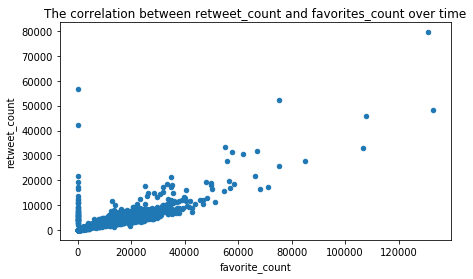

In [49]:
### The retweet counts and favorite counts comparison over time.

twitter_master_df.plot.scatter(x="favorite_count", y="retweet_count", figsize=(7, 4))
plt.title("The correlation between retweet_count and favorites_count over time")

> We could see that there is a positive correlation between retweet_count and favorites_count

In [50]:
### Most common names

twitter_master_df.name.value_counts()

Bo          2
Gromit      1
Astrid      1
Loki        1
Milo        1
Peaches     1
Rizzy       1
Colby       1
Walter      1
Rusty       1
Ken         1
Tucker      1
Paull       1
Chelsea     1
Rubio       1
Betty       1
Davey       1
Ruby        1
Klein       1
Cali        1
Scout       1
Moreton     1
Kenny       1
Stubert     1
Stephan     1
Sampson     1
Bruce       1
Harper      1
Sunny       1
Arnie       1
Lola        1
Lilly       1
Hercules    1
Paisley     1
Dave        1
Penny       1
Maximus     1
Chompsky    1
Bell        1
Frankie     1
Larry       1
Butter      1
Happy       1
Bailey      1
Alfie       1
Canela      1
Name: name, dtype: int64

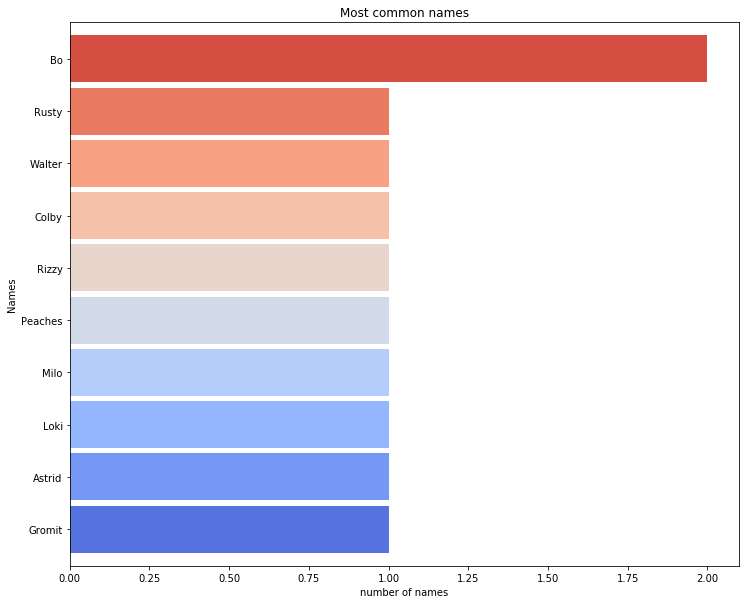

In [51]:
# Get list of names
namesList = twitter_master_df.name.value_counts()[:10].sort_values(ascending=True)
    
# Plot based on the value counts
plt.subplots(figsize=(12,10))
namesList.plot.barh(width=0.9,color=sns.color_palette('coolwarm',10))
plt.title('Most common names')
plt.xlabel('number of names')
plt.ylabel('Names')
plt.show()

> As we could see in the chart, "Bo" is the most common name for dogs

In [52]:
### Most common dog types appeared on twitter

twitter_master_df.dog_type.value_counts()

doggo     4
pupper    2
puppo     1
Name: dog_type, dtype: int64

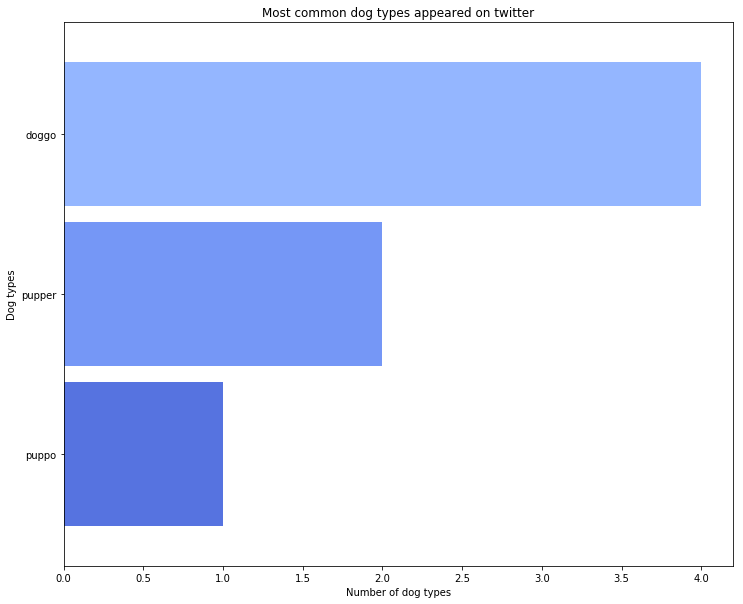

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# get list dog types
dogTypeList = twitter_master_df.dog_type.value_counts()[:10].sort_values(ascending=True)
    
# Plot based on the value counts
plt.subplots(figsize=(12,10))
dogTypeList.plot.barh(width=0.9,color=sns.color_palette('coolwarm',10))
plt.title('Most common dog types appeared on twitter')
plt.xlabel('Number of dog types')
plt.ylabel('Dog types')
plt.show()

> The most popular dog type here on Twitter is "doggo"